In [1]:
from pathlib import Path
import os
import requests
import zipfile

coco_path = Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download")
train_path = coco_path / "train2017"
val_path= coco_path / "val2017"
annotations_path = coco_path / "annotations"



In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import json
from pathlib import Path
from matplotlib import pyplot as plt

import numpy as np

def show_image_from_tensor(image_tensor):
    # 3 x 256 x 256
    image = image_tensor.numpy().transpose((1, 2, 0))
    image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

if False:
    class CocoDataset(Dataset):
        def __init__(self, image_dir, annotations_file=None, transform=None):
            self.image_dir = Path(image_dir)
            self.image_paths = sorted(self.image_dir.glob("*.jpg"))  # Load all JPGs
            self.transform = transform
            self.annotations = None
            
            if annotations_file:
                with open(annotations_file, "r") as f:
                    self.annotations = json.load(f)

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert("RGB")

            if self.transform:
                image = self.transform(image)

            # Return image only (modify if annotations are needed)
            return image

    # Instantiate datasets
    train_dataset = CocoDataset(train_path, transform=transform)
    val_dataset = CocoDataset(val_path, transform=transform)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Example batch
    sample_batch = next(iter(val_loader))
    print(sample_batch.shape)  # Should print [32, 3, 256, 256]

    print(sample_batch[0].shape)  # Should print [32, 3, 256, 256]


In [41]:
from collections import defaultdict

def get_image_num(image_path):
    # Extract the image number from the filename
    # Assuming filenames are like '000000000001.jpg'
    return int(image_path.stem)  # stem gives the filename without extension
class CocoDataset(Dataset):
    def __init__(self, image_dir, annotations_file=None, transform=None):
        self.image_dir = Path(image_dir)
        self.image_paths = sorted(self.image_dir.glob("*.jpg"))  # Load all JPGs
        self.transform = transform

        if annotations_file is None:
            self.annotations_file = annotations_path / "instances_train2017.json"
        self.annotations = None
        
        if self.annotations_file:
            with open(self.annotations_file, "r") as f:
                self.annotations = json.load(f)


            ### BEEP BOOP BAAP

            # Extract key data
            annotations = self.annotations["annotations"]  # List of object 
            annotation_counts_per_image = defaultdict(int)  # Dictionary to count annotations per image
            image_id_to_categories = defaultdict(list)  # Dictionary to map image IDs to categories

            for ann in annotations:
                image_id = ann['image_id']
                category_id = ann['category_id']
                annotation_counts_per_image[image_id] += 1
                image_id_to_categories[image_id].append(category_id)
                # sort image_id_to_category keys
            print(f"len image_id_to_category -- {len(image_id_to_categories)}")
        
            image_id_to_categories = dict(sorted(image_id_to_categories.items(), key=lambda item: item[0]))
            # missing image ids
            # remove missing image ids from img_path
            #missing_image_ids = set(range(len(self.image_paths))) - set(image_id_to_categories.keys())
            #self.image_paths = [img_path for i, img_path in enumerate(self.image_paths) if i not in missing_image_ids]
            
            self.image_paths = {get_image_num(img_path): img_path for img_path in self.image_paths if get_image_num(img_path) in image_id_to_categories}

            # create labels for each image, which is the category of the most common annotation, tie breaking should be the first annotation (sorted)
            image_id_to_top_label = {}

            for k,v in image_id_to_categories.items():
                # get the most common category
                from collections import Counter
                most_common = Counter(v).most_common(1)
                # get the category id
                if len(most_common) == 0:
                    print(f"Image ID {k} has no annotations.")
                    continue
                image_id_to_top_label[k] = most_common[0][0]
            
            self.image_id_to_top_label = image_id_to_top_label
            self.image_id_to_categories = image_id_to_categories
            print(f"len image_id_to_top_label -- {len(self.image_id_to_top_label)}")
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform: 
            image = self.transform(image)
        top_label = self.image_id_to_top_label.get(idx, -1)
        print(f"image id {idx} has {self.image_id_to_top_label.get(idx, -1)} annotations ; top label - {top_label}")
        print(f"image_path = {img_path}")

        # Return image only (modify if annotations are needed)
        return image, top_label


# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize for consistency
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Instantiate datasets
train_dataset = CocoDataset(train_path, transform=transform)
val_dataset = CocoDataset(val_path, transform=transform)
if False:
    valid_train_inds = [i for i,label in train_dataset.image_id_to_top_label.items()  if label != None]
    valid_val_inds = [i for i,label in val_dataset.image_id_to_top_label.items()  if label != None]

    #valid_val_inds = [i for i in val_dataset.image_id_to_top_label.keys() != None]
    train_dataset = torch.utils.data.Subset(train_dataset, valid_train_inds)
    val_dataset = torch.utils.data.Subset(val_dataset, valid_val_inds)

if False:
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Example batch
    sample_batch = next(iter(val_loader))
    print(type(sample_batch))  # Should print [32, 3, 256, 256]

    print(sample_batch[0].shape)  # Should print 


len image_id_to_category -- 117266
len image_id_to_top_label -- 117266
len image_id_to_category -- 117266
len image_id_to_top_label -- 117266


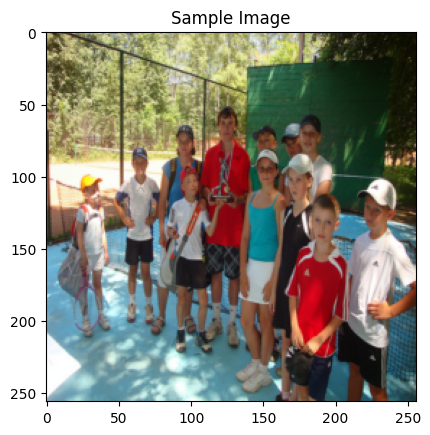

In [17]:
# show image
import matplotlib.pyplot as plt
import numpy as np
def imshow(tensor, title=None):
    image = tensor.numpy().transpose((1, 2, 0))
    image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

imshow(sample_batch[0][0], title="Sample Image")

# Extract some metadata about the image dataset

In [18]:
# list one annotation
import json
from pathlib import Path

if False:
    # Load COCO annotation file
    annotations_file = annotations_path / "instances_train2017.json"  # Change to val2017 if needed

    with open(annotations_file, "r") as f:
        coco_data = json.load(f)

coco_data = train_dataset.annotations
# Extract key data
images = coco_data["images"]  # List of image metadata
annotations = coco_data["annotations"]  # List of object annotations
categories = coco_data["categories"]  # List of category mappings

category_id_to_name = {cat['id']: cat['name'] for cat in categories}
category_to_images = {}
# Create a mapping of category IDs to image IDs
for ann in annotations:
    category_id = ann['category_id']
    image_id = ann['image_id']
    if category_id not in category_to_images:
        category_to_images[category_id] = []
    category_to_images[category_id].append(image_id)


annotation_counts_per_image = {}
image_id_to_category = {}

for ann in annotations:
    image_id = ann['image_id']
    category_id = ann['category_id']
    if image_id not in annotation_counts_per_image:
        annotation_counts_per_image[image_id] = 0
    annotation_counts_per_image[image_id] += 1

    if image_id not in image_id_to_category:
        image_id_to_category[image_id] = []
    image_id_to_category[image_id].append(category_id)

# List the first 5 image metadata entries
print("First 5 Images Metadata:")
for img in images[:5]:
    print(f"ID: {img['id']}, File: {img['file_name']}, Size: {img['width']}x{img['height']}")

# List the first 5 annotations
print("\nFirst 5 Annotations:")
for ann in annotations[:5]:
    category = ann["category_id"]
    category_name = category_id_to_name.get(category, "Unknown")
    
    print(f"Image ID: {ann['image_id']}, Category: {ann['category_id']}, BBox: {ann['bbox']} -- {category_name}")


# List category mapping
print("\nCategories:")
for cat in categories:
    print(f"ID: {cat['id']}, Name: {cat['name']}")



First 5 Images Metadata:
ID: 391895, File: 000000391895.jpg, Size: 640x360
ID: 522418, File: 000000522418.jpg, Size: 640x480
ID: 184613, File: 000000184613.jpg, Size: 500x336
ID: 318219, File: 000000318219.jpg, Size: 556x640
ID: 554625, File: 000000554625.jpg, Size: 426x640

First 5 Annotations:
Image ID: 558840, Category: 58, BBox: [199.84, 200.46, 77.71, 70.88] -- hot dog
Image ID: 200365, Category: 58, BBox: [234.22, 317.11, 149.39, 38.55] -- hot dog
Image ID: 200365, Category: 58, BBox: [239.48, 347.87, 160.0, 57.81] -- hot dog
Image ID: 200365, Category: 58, BBox: [296.65, 388.33, 1.03, 0.0] -- hot dog
Image ID: 200365, Category: 58, BBox: [251.87, 333.42, 125.94, 22.71] -- hot dog

Categories:
ID: 1, Name: person
ID: 2, Name: bicycle
ID: 3, Name: car
ID: 4, Name: motorcycle
ID: 5, Name: airplane
ID: 6, Name: bus
ID: 7, Name: train
ID: 8, Name: truck
ID: 9, Name: boat
ID: 10, Name: traffic light
ID: 11, Name: fire hydrant
ID: 13, Name: stop sign
ID: 14, Name: parking meter
ID: 15,

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
loading image path : /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000558840.jpg


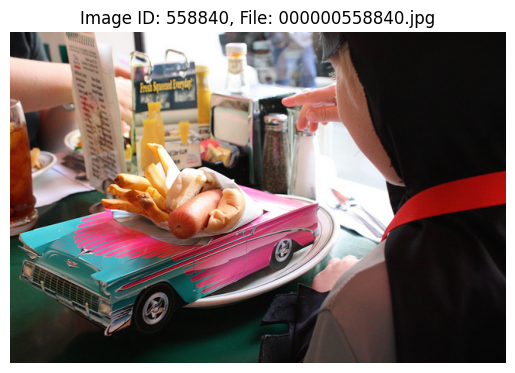

In [32]:
print(coco_data.keys())
# show image 558840
def show_image_from_id(image_id):
    # Find the image metadata
    image_info = next((img for img in coco_data["images"] if img["id"] == image_id), None)
    if not image_info:
        print(f"Image ID {image_id} not found.")
        return

    # Load the image
    img_path = train_path / image_info["file_name"]
    image = Image.open(img_path).convert("RGB")
    print(f"loading image path : {img_path}")
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image ID: {image_id}, File: {image_info['file_name']}")
    plt.show()
id_ = 558840
show_image_from_id(id_)

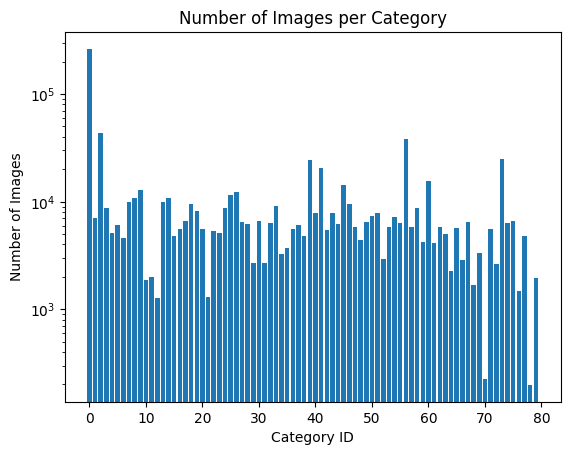

Top 3 Categories:
Category ID: 1, person : Count: 262465
Category ID: 3, car : Count: 43867
Category ID: 62, chair : Count: 38491

Bottom 3 Categories:
Category ID: 89, hair drier :  Count: 198
Category ID: 80, toaster :  Count: 225
Category ID: 14, parking meter :  Count: 1285


In [20]:
# sort category_to_images
category_to_images = dict(sorted(category_to_images.items()))

# plot hist of category_to_images counts
import matplotlib.pyplot as plt
counts = [len(image_ids) for image_ids in category_to_images.values()]
# plot bars
plt.bar(range(len(counts)), counts)
plt.xlabel('Category ID')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category')
plt.yscale('log')
plt.show()


# print top 3 and bottom 3 categories
top_3 = sorted(category_to_images.items(), key=lambda x: len(x[1]), reverse=True)[:3]
bottom_3 = sorted(category_to_images.items(), key=lambda x: len(x[1]))[:3]
print("Top 3 Categories:")
for cat_id, image_ids in top_3:
    cat_name = category_id_to_name.get(cat_id, "Unknown")
    print(f"Category ID: {cat_id}, {cat_name} : Count: {len(image_ids)}")
print("\nBottom 3 Categories:")
for cat_id, image_ids in bottom_3:
    cat_name = category_id_to_name.get(cat_id, "Unknown")
    print(f"Category ID: {cat_id}, {cat_name} :  Count: {len(image_ids)}")

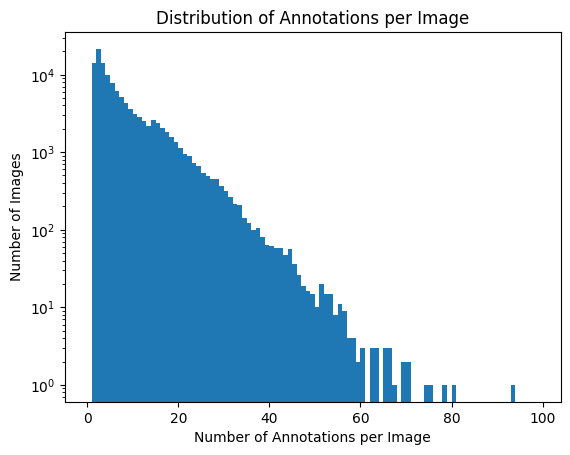

In [21]:
# plot annotation_counts_per_image
# plot hist of annotation_counts_per_image.values()
# bins 0 to 100
bins = np.arange(0, 100, 1)

plt.hist(list(annotation_counts_per_image.values()), bins = bins)#, bins=np.arange(1, 20), log=True)
plt.xlabel('Number of Annotations per Image')
plt.ylabel('Number of Images')
plt.title('Distribution of Annotations per Image')
plt.yscale('log')
plt.show()

## Construct single-class labels associated with the most common annotation for each image 

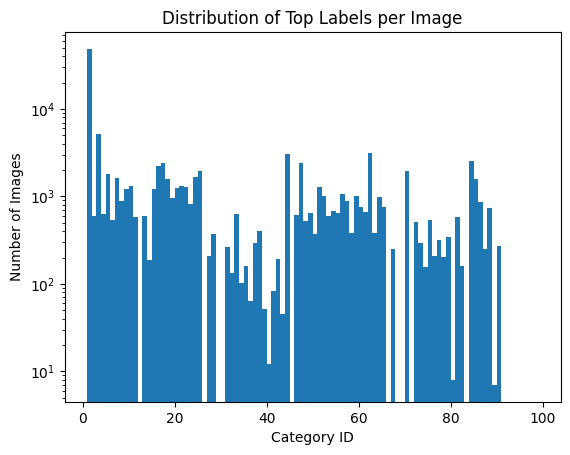

In [22]:
# create labels for each image, which is the category of the most common annotation, tie breaking should be the first annotation (sorted)

# sort lists of category_id
for k,v in image_id_to_category.items():
    image_id_to_category[k] = sorted(v)
# sort image_id_to_category keys
image_id_to_category = dict(sorted(image_id_to_category.items(), key=lambda item: item[0]))
image_id_to_category
# create labels for each image, which is the category of the most common annotation, tie breaking should be the first annotation (sorted)
image_id_to_top_label = {}

for k,v in image_id_to_category.items():
    # get the most common category
    from collections import Counter
    most_common = Counter(v).most_common(1)
    # get the category id
    if len(most_common) == 0:
        print(f"Image ID {k} has no annotations.")
        continue
    image_id_to_top_label[k] = most_common[0][0]
image_id_to_top_label 
# plot image_id_to_top_label histogram of labels
plt.hist(list(image_id_to_top_label.values()), bins=np.arange(1, 100), log=True)
plt.xlabel('Category ID')
plt.ylabel('Number of Images')
plt.title('Distribution of Top Labels per Image')
plt.yscale('log')
plt.show()

## Get a sense of what the top labels are going to look like

Category ID: 1, person
image id : 36; shape -- torch.Size([3, 256, 256])
other categories:
	person (1)
	umbrella (28)


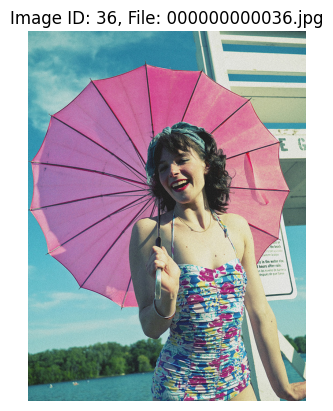

Category ID: 2, bicycle
image id : 775; shape -- torch.Size([3, 256, 256])
other categories:
	bicycle (2)
	car (3)
	motorcycle (4)


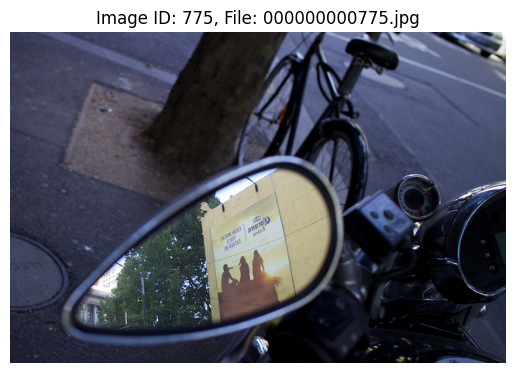

Category ID: 3, car
image id : 64; shape -- torch.Size([3, 256, 256])
other categories:
	car (3)
	truck (8)
	stop sign (13)
	clock (85)


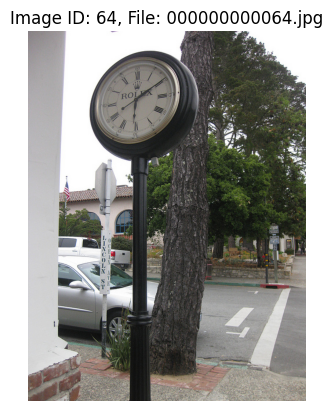

Category ID: 4, motorcycle
image id : 73; shape -- torch.Size([3, 256, 256])
other categories:
	motorcycle (4)
	motorcycle (4)


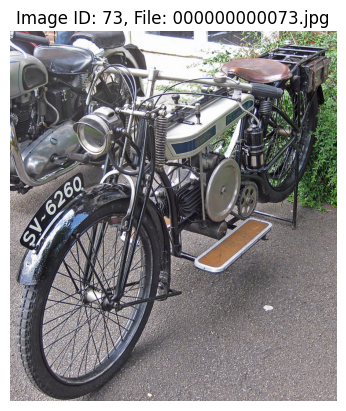

Category ID: 5, airplane
image id : 81; shape -- torch.Size([3, 256, 256])
other categories:
	airplane (5)


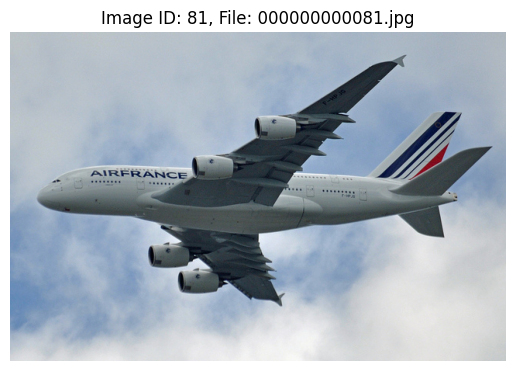

Category ID: 6, bus
image id : 681; shape -- torch.Size([3, 256, 256])
other categories:
	bus (6)


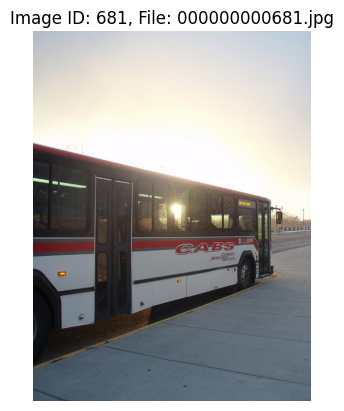

Category ID: 7, train
image id : 1090; shape -- torch.Size([3, 256, 256])
other categories:
	train (7)


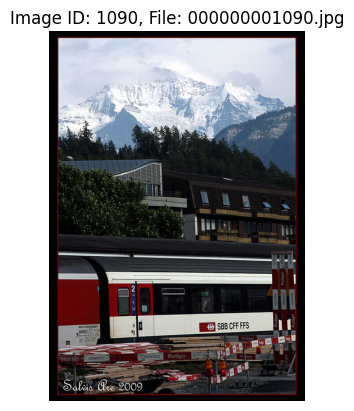

Category ID: 8, truck
image id : 1590; shape -- torch.Size([3, 256, 256])
other categories:
	truck (8)
	cow (21)


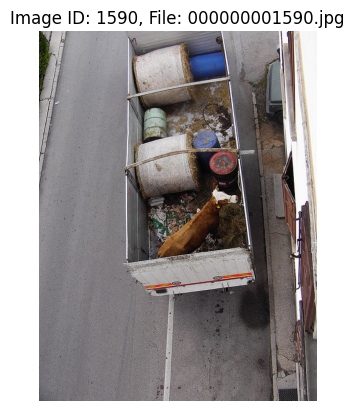

Category ID: 9, boat
image id : 400; shape -- torch.Size([3, 256, 256])
other categories:
	boat (9)
	dog (18)


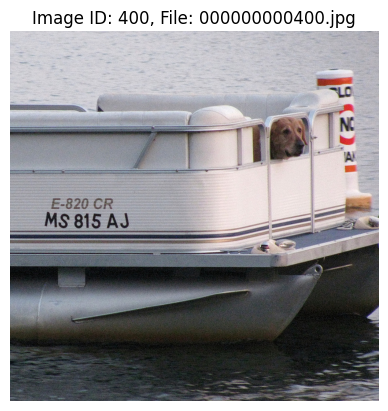

In [23]:
# show me an image with the top label = 1

label_ = 3
for label_ in range(1,10):
    # get the image id
    # print thename of hte category
    cat_name = category_id_to_name.get(label_, "Unknown")
    # get rest of categories
    print(f"Category ID: {label_}, {cat_name}")
    image_id = [k for k,v in image_id_to_top_label.items() if v == label_][0]
    # show the image
    print(f"image id : {image_id}; shape -- {train_dataset[image_id][0].shape}")
    other_categories = image_id_to_category[image_id]
    print(f"other categories:")
    for cat in other_categories:
        cat_name = category_id_to_name.get(cat, "Unknown")
        print(f"\t{cat_name} ({cat})")
    # print(f"Other categories: {other_categories}")
    show_image_from_id(image_id)

    

# train a Neural Net

In [24]:
image_id_to_top_label[9]

55

In [25]:
ids = sorted(list(image_id_to_top_label.keys()))
print(ids[:10])



[9, 25, 30, 34, 36, 42, 49, 61, 64, 71]


id_ = 30
image id 30 has 64 annotations ; top label - 64
image_path = /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000030.jpg
label - 64, category - potted plant
image shape torch.Size([3, 256, 256])


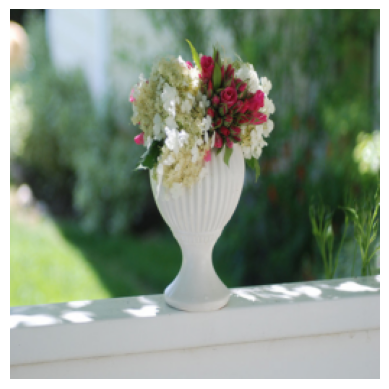

loading image from coco_data directly
loading image path : /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000030.jpg


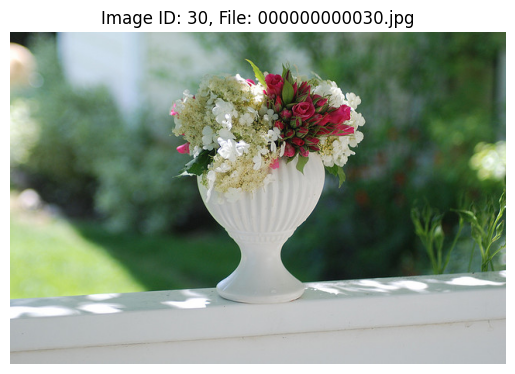

Image ID: 30, Label: 64 - potted plant


In [42]:
id_ = ids[2]
print(f"id_ = {id_}")

image, label = train_dataset[id_]
print(f"label - {label}, category - {category_id_to_name.get(label, 'Unknown')}")
print(f"image shape {image.shape}")

show_image_from_tensor(image) # loads from coco_dataset_single_class


print(f"loading image from coco_data directly")
show_image_from_id(id_) # loads from coco_data


print(f"Image ID: {id_}, Label: {label} - {category_id_to_name.get(label, 'Unknown')}")


In [43]:
train_dataset.image_paths

{9: PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000009.jpg'),
 25: PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000025.jpg'),
 30: PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000030.jpg'),
 34: PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000034.jpg'),
 36: PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000036.jpg'),
 42: PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000042.jpg'),
 49: PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000049.jpg'),
 61: PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000061.jpg'),
 64: PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000064.jpg'),
 71: PosixPath('/n/home04/rri